In [1]:
import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from collections import Counter
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, GaussianBlur, Grayscale
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset, Dataset

import cv2 
from PIL import Image, ImageFilter, ImageOps
from torchvision.transforms.functional import to_pil_image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.optim import lr_scheduler

from tkinter import filedialog, Tk

from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam
from lime import lime_image
from skimage.segmentation import mark_boundaries
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import dill
import torch.multiprocessing as mp

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

import platform
import psutil
import GPUtil
from tabulate import tabulate

In [11]:
# Operating System
os_platform = platform.platform()

# Processor Architecture
processor_architecture = platform.architecture()

# Machine Network Name
machine_name = platform.node()

# Processor Name
processor_name = platform.processor()

# System Architecture
system_architecture = platform.machine()

# Python Version
python_version = platform.python_version()

# CPU information
cpu_count = psutil.cpu_count(logical=False)  # Physical CPU count
cpu_logical_count = psutil.cpu_count(logical=True)  # Logical CPU count
cpu_freq = psutil.cpu_freq()  # CPU frequency

# GPU information
gpus = GPUtil.getGPUs()
gpu_count = len(gpus)
gpu_specs = [(gpu.name, gpu.memoryTotal) for gpu in gpus]  # GPU name and total memory

# RAM information
total_memory = psutil.virtual_memory().total  # Total system memory

# Format data into a table
table_data = [
    ["Operating System", os_platform],
    ["Processor Architecture", processor_architecture],
    ["Machine Network Name", machine_name],
    ["Processor Name", processor_name],
    ["System Architecture", system_architecture],
    ["Python Version", python_version],
    ["Physical CPU Count", cpu_count],
    ["Logical CPU Count", cpu_logical_count],
    ["CPU Frequency (MHz)", cpu_freq],
    ["GPU Count", gpu_count],
    ["Total Memory (GB)", total_memory / (1024 ** 3)]
]

# Print table
print(table_data)
print(tabulate(table_data, headers=["Specification", "Value"], tablefmt="fancy_grid"))

[['Operating System', 'macOS-10.16-x86_64-i386-64bit'], ['Processor Architecture', ('64bit', '')], ['Machine Network Name', 'Savins-MacBook-Air.local'], ['Processor Name', 'i386'], ['System Architecture', 'x86_64'], ['Python Version', '3.9.7'], ['Physical CPU Count', 8], ['Logical CPU Count', 8], ['CPU Frequency (MHz)', scpufreq(current=2400, min=2400, max=2400)], ['GPU Count', 0], ['Total Memory (GB)', 8.0]]
╒════════════════════════╤════════════════════════════════════════════╕
│ Specification          │ Value                                      │
╞════════════════════════╪════════════════════════════════════════════╡
│ Operating System       │ macOS-10.16-x86_64-i386-64bit              │
├────────────────────────┼────────────────────────────────────────────┤
│ Processor Architecture │ ('64bit', '')                              │
├────────────────────────┼────────────────────────────────────────────┤
│ Machine Network Name   │ Savins-MacBook-Air.local                   │
├──────────

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class CNN1(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(384)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(384 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.output = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.01)
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn6(self.conv6(x)), negative_slope=0.01)

        x = x.view(x.size(0), -1)

        x = self.dropout(F.leaky_relu(self.fc1(x), negative_slope=0.01))
        x = self.dropout(F.leaky_relu(self.fc2(x), negative_slope=0.01))
        
        x = self.output(x)

        return x

model1 = CNN1(num_classes=4)

print(model1)
summary(model1, (3,224,224))

CNN1(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_run

In [4]:
model = CNN1()

file_path = '/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model1_test2.pth'

model.load_state_dict(torch.load(file_path))

model.eval()

CNN1(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_run

In [5]:
class ContrastStretching:
    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Check if the image is grayscale or RGB
        if img_np.ndim == 2:  # Grayscale image
            img_np = self.apply_contrast_stretching(img_np)
        elif img_np.ndim == 3:  # RGB image
            # Apply contrast stretching to each channel individually
            for i in range(img_np.shape[-1]):
                img_np[:, :, i] = self.apply_contrast_stretching(img_np[:, :, i])
        
        # Convert back to PIL Image
        return Image.fromarray(img_np.astype('uint8'))
    
    def apply_contrast_stretching(self, channel):
        in_min, in_max = np.percentile(channel, (0, 100))
        out_min, out_max = 0, 255
        channel = np.clip((channel - in_min) * (out_max - out_min) / (in_max - in_min) + out_min, out_min, out_max)
        return channel

class UnsharpMask:
    def __init__(self, radius=1, percent=100, threshold=3):
        self.radius = radius
        self.percent = percent
        self.threshold = threshold

    def __call__(self, img):
        return img.filter(ImageFilter.UnsharpMask(radius=self.radius, 
                                                  percent=self.percent, 
                                                  threshold=self.threshold
                                                 ))

class GaussianBlur:
    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        sigma = np.random.uniform(self.sigma[0], self.sigma[1])
        img = img.filter(ImageFilter.GaussianBlur(sigma))
        return img

preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    ContrastStretching(),
    UnsharpMask(radius=1, percent=100, threshold=3),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
])

# Preprocessing function
def preprocess_image(image_path):
    # Open the image file
    image = Image.open(image_path)

    # Convert the image to RGB if it is not already
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Apply the preprocessing transforms
    image_tensor = preprocess_transform(image).unsqueeze(0).to(device)

    return image_tensor, image

In [6]:
def load_and_predict(image_path, model, transform, device, class_names):
    model.eval()
    image = Image.open(image_path)# Convert to grayscale
    image = transform(image)
    image = image.repeat(3, 1, 1)  # Repeat the single channel three times to create a 3-channel image
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

Tk().withdraw()
image_path = filedialog.askopenfilename()

if image_path:
    predicted_class = load_and_predict(image_path, model, preprocess_transform, device, class_names)
    print(f'Predicted class: {predicted_class}')
    print(image_path)
else:
    print("No file was selected.")

2024-03-23 21:26:22.767 python[35035:585870] +[CATransaction synchronize] called within transaction


Predicted class: Non Demented
/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/Test_Dataset/NonDemented/nonDem2550.jpg


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


# Grad-CAM 

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


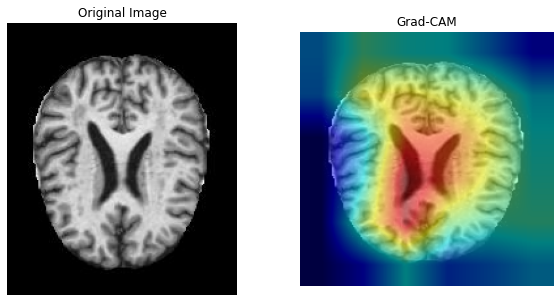

In [8]:
image_path = "/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/Test_Dataset/NonDemented/nonDem2550.jpg"

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

# Grad-CAM function
def apply_gradcam(model, image_tensor, target_layer):
    gradcam = GradCAM(model, target_layer)
    mask, _ = gradcam(image_tensor)
    heatmap, result = visualize_cam(mask, image_tensor)

    return heatmap, result

# Load and preprocess image
input_image_path = image_path
image_tensor, original_image = preprocess_image(input_image_path)

# Apply Grad-CAM (adjust target layer as needed)
target_layer = model.conv6  # Example: last conv layer in features
heatmap, cam_result = apply_gradcam(model, image_tensor, target_layer)

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_result.permute(1, 2, 0).cpu().numpy())
plt.title('Grad-CAM')
plt.axis('off')

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


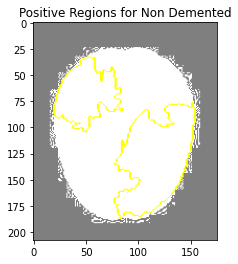

In [9]:
def model_prediction(image_tensor):
    """
    This function will take an image tensor, apply the model prediction,
    and return the prediction probabilities for each class.
    The model should return the raw scores (logits) which we will then pass
    through a softmax to get probabilities.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        logits = model(image_tensor)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        return probabilities.cpu().numpy()

def batch_predict(images):
    """
    This function will receive a batch of images and return their class probabilities.
    """
    image_tensors = torch.stack([preprocess_transform(Image.fromarray(img)) for img in images])
    return model_prediction(image_tensors)

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()


image = Image.open(image_path)
image = image.convert('RGB')  # Ensure image is in RGB

# Preprocess image and predict
preprocessed_image = preprocess_transform(image).unsqueeze(0)

# Explanation with LIME
explanation = explainer.explain_instance(np.array(image),
                                         batch_predict,  # classification function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)  # number of images that will be sent to classification function

# Visualization
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)
plt.imshow(img_boundry1)
plt.title('Positive Regions for {}'.format(class_names[explanation.top_labels[0]]))
plt.show()

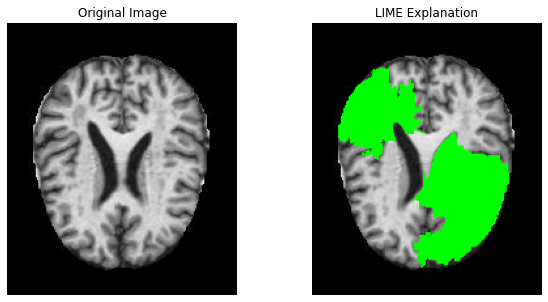

In [12]:
color = np.array([0, 255, 0])  

# Retrieve image and mask for the top class prediction
image, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=False
)

# Convert the original image to RGB if it's grayscale
if image.ndim == 2:
    image = gray2rgb(image)

# We can apply the mask to the image and fill the areas with the chosen color
# Make sure the image is uint8
image = image.astype(np.uint8)
colored_image = image.copy()

for i in range(3):  # Assuming mask is a 2D array and image is 3D (H, W, C)
    colored_image[:, :, i] = np.where(mask, color[i], image[:, :, i])

# Display the original image and the one with highlighted areas
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colored_image)
plt.title('LIME Explanation')
plt.axis('off')

plt.show()

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


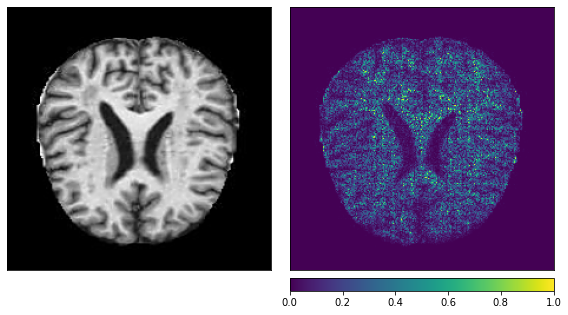

In [10]:
def apply_integrated_gradients(model, image_tensor, target=None, device='cpu'):
    model.to(device).eval()
    image_tensor = image_tensor.to(device)
    
    integrated_gradients = IntegratedGradients(model)

    # If no target is provided, use the most likely class prediction
    if target is None:
        output = model(image_tensor)
        target = output.argmax(dim=1)

    # Calculate the integrated gradients
    attributions_ig = integrated_gradients.attribute(image_tensor, target=target, n_steps=200)

    # Convert the computed gradients to numpy for visualization
    attributions_ig = attributions_ig.squeeze().cpu().detach().numpy()

    # Normalize the input image for visualization
    norm_img_tensor = image_tensor.squeeze().cpu().detach().numpy()
    if norm_img_tensor.ndim == 3:  # If image is 3D (channels, height, width), convert to 2D
        norm_img_tensor = np.moveaxis(norm_img_tensor, 0, -1)  # Convert to (height, width, channels)
    norm_img_tensor = (norm_img_tensor - norm_img_tensor.min()) / (norm_img_tensor.max() - norm_img_tensor.min())

    # Convert grayscale attributions to RGB if they are not already
    if attributions_ig.ndim == 2:  # Grayscale attribution, no need for channel dimension
        attributions_ig = np.stack((attributions_ig,)*3, axis=-1)
    elif attributions_ig.ndim == 3:
        attributions_ig = np.moveaxis(attributions_ig, 0, -1)  # Convert to (height, width, channels)

    # Visualize the attributions
    fig, axis = viz.visualize_image_attr_multiple(
        attributions_ig,
        norm_img_tensor,
        methods=["original_image", "heat_map"],
        signs=["all", "absolute_value"],
        cmap='viridis',
        show_colorbar=True
    )

    return fig, axis

# Assuming you have a preprocessed image tensor
# Apply the Integrated Gradients method
fig, axis = apply_integrated_gradients(model1, image_tensor, device=device)
plt.show()

## EfficientNetB0

In [10]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=32):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class CNN2(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN2, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a new one
        num_ftrs = self.base_model.classifier[1].in_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        self.base_model.features.add_module("SEBlock", SEBlock(1280)) 

    def forward(self, x):
        x = self.base_model.features(x)
        
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Creating the model and moving to device
model2 = CNN2(num_classes=4).to(device)

summary(model2, (3, 224, 224))

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [11]:
model2 = CNN2()

file_path = '/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_test1.pth'

model2.load_state_dict(torch.load(file_path))

model2.eval()

CNN2(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activ

In [12]:
def load_and_predict(image_path, model, transform, device, class_names):
    model.eval()
    image = Image.open(image_path)# Convert to grayscale
    image = transform(image)
    image = image.repeat(3, 1, 1)  # Repeat the single channel three times to create a 3-channel image
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

Tk().withdraw()
image_path = filedialog.askopenfilename()

if image_path:
    predicted_class = load_and_predict(image_path, model2, preprocess_transform, device, class_names)
    print(f'Predicted class: {predicted_class}')
    print(image_path)
else:
    print("No file was selected.")

2024-03-23 21:27:11.753 python[35035:585870] +[CATransaction synchronize] called within transaction
2024-03-23 21:27:11.773 python[35035:585870] +[CATransaction synchronize] called within transaction
2024-03-23 21:27:14.886 python[35035:585870] +[CATransaction synchronize] called within transaction


Predicted class: Very Mild Demented
/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/Test_Dataset/NonDemented/nonDem2550.jpg


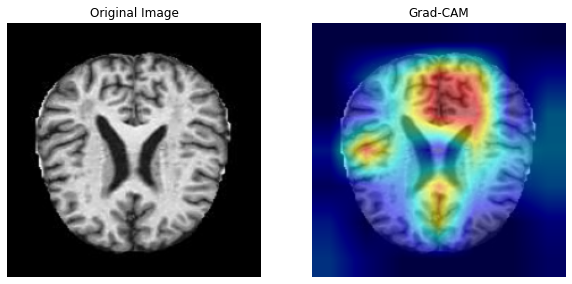

In [13]:
# Grad-CAM function adjusted for CustomEfficientNet
input_image_path = image_path
image_tensor, original_image = preprocess_image(input_image_path)

activations = {}
gradients = {}

def save_activation(name):
    def hook(module, input, output):
        activations[name] = output
    return hook

def save_gradient(name):
    def hook(module, input, output):
        gradients[name] = output[0]
    return hook

def apply_gradcam_efficientnet(model, image_tensor, target_layer_name):
    target_layer = dict([*model.base_model.features.named_children()])[target_layer_name]
    target_layer.register_forward_hook(save_activation(target_layer_name))
    target_layer.register_full_backward_hook(save_gradient(target_layer_name))
    
    # Forward pass
    model.eval()
    logits = model(image_tensor)
    pred_class_idx = logits.argmax(dim=1).item()
    score = logits[:, pred_class_idx]
    
    # Backward pass
    model.zero_grad()
    score.backward()
    
    # Access the stored data
    gradient = gradients[target_layer_name][0].cpu()  
    activation = activations[target_layer_name][0].cpu()
    
    if not isinstance(gradient, torch.Tensor):
        gradient = torch.from_numpy(gradient)
    if not isinstance(activation, torch.Tensor):
        activation = torch.from_numpy(activation)
    
    if gradient.ndim == 3:
        gradient = gradient[np.newaxis, :]

    # Use the gradient and activation to compute the weighted activation maps
    b, k, u, v = gradient.size()
    alpha = gradient.view(b, k, -1).mean(2, keepdim=True)
    weights = alpha.view(b, k, 1, 1)

    saliency_map = torch.mul(weights, activation).sum(1, keepdim=True)
    saliency_map = F.relu(saliency_map)
    saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
    
    # Normalize the saliency map
    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
    saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)
    
    grayscale_img = np.float32(image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0))
    if grayscale_img.shape[2] == 3:
        grayscale_img = np.mean(grayscale_img, axis=2)
    grayscale_img = np.stack((grayscale_img,)*3, axis=-1)
    grayscale_img -= np.min(grayscale_img)
    grayscale_img /= np.max(grayscale_img)
    
    # Prepare the heatmap
    saliency_map_np = saliency_map.squeeze().detach().numpy()
    heatmap = np.uint8(255 * saliency_map_np)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) 

    # Apply heatmap to the original image
    heatmap = np.float32(heatmap) / 255
    original_image = np.float32(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy())
    original_image = original_image - np.min(original_image)
    original_image = original_image / np.max(original_image)

    alpha = 0.5  # Transparency for the heatmap
    cam_result = (alpha * heatmap) + ((1 - alpha) * grayscale_img)
    cam_result = cam_result / np.max(cam_result)

    return cam_result

def get_activation(name):
    def hook(model, input, output):
        activation_maps[name] = output.detach()
    return hook

def get_gradients(name):
    def hook(model, input, output):
        gradients[name] = output[0].detach()
    return hook

# Usage Example:
# Apply Grad-CAM to the EfficientNet model
target_layer = dict([*model2.base_model.features.named_children()])['SEBlock']
cam_result = apply_gradcam_efficientnet(model2, image_tensor, 'SEBlock')

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(image_tensor.squeeze().cpu().numpy(), (1, 2, 0)))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_result)
plt.title('Grad-CAM')
plt.axis('off')

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


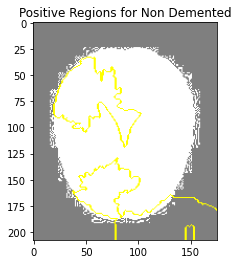

In [14]:
model2.eval()

def model2_prediction(image_tensor):
    """
    This function will take an image tensor, apply model2's prediction,
    and return the prediction probabilities for each class.
    """
    with torch.no_grad():
        logits = model2(image_tensor)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        return probabilities.cpu().numpy()

def batch_predict(images):
    """
    This function will receive a batch of images, preprocess them,
    and return their class probabilities using model2.
    """
    image_tensors = torch.stack([preprocess_transform(Image.fromarray(img)) for img in images])
    return model2_prediction(image_tensors)

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Explanation with LIME for model2
explanation = explainer.explain_instance(np.array(image),
                                         batch_predict,  # Use the batch_predict function for model2
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)  # number of images that will be sent to classification function

# Visualization of LIME explanation for model2
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)
plt.imshow(img_boundry1)
plt.title('Positive Regions for {}'.format(class_names[explanation.top_labels[0]]))
plt.show()

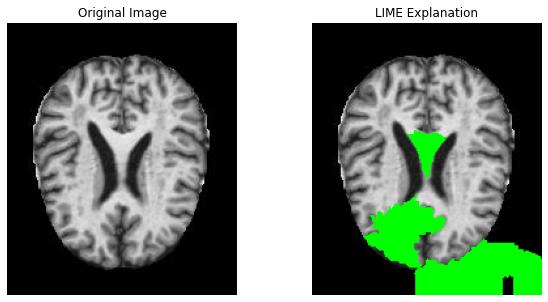

In [15]:
color = np.array([0, 255, 0])  

# Retrieve image and mask for the top class prediction
image, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False
)

# Convert the original image to RGB if it's grayscale
if image.ndim == 2:
    image = gray2rgb(image)

# We can apply the mask to the image and fill the areas with the chosen color
# Make sure the image is uint8
image = image.astype(np.uint8)
colored_image = image.copy()

for i in range(3):  # Assuming mask is a 2D array and image is 3D (H, W, C)
    colored_image[:, :, i] = np.where(mask, color[i], image[:, :, i])

# Display the original image and the one with highlighted areas
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colored_image)
plt.title('LIME Explanation')
plt.axis('off') 

plt.show()

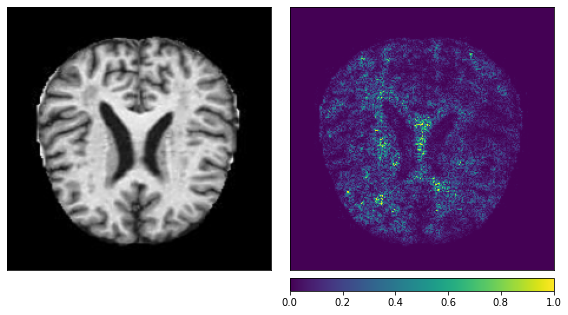

In [16]:
def apply_integrated_gradients(model, image_tensor, target=None, device='cpu'):
    model.to(device).eval()
    image_tensor = image_tensor.to(device)
    
    integrated_gradients = IntegratedGradients(model)

    # If no target is provided, use the most likely class prediction
    if target is None:
        output = model(image_tensor)
        target = output.argmax(dim=1)

    # Calculate the integrated gradients
    attributions_ig = integrated_gradients.attribute(image_tensor, target=target, n_steps=200)

    # Convert the computed gradients to numpy for visualization
    attributions_ig = attributions_ig.squeeze().cpu().detach().numpy()

    # Normalize the input image for visualization
    norm_img_tensor = image_tensor.squeeze().cpu().detach().numpy()
    if norm_img_tensor.ndim == 3:  # If image is 3D (channels, height, width), convert to 2D
        norm_img_tensor = np.moveaxis(norm_img_tensor, 0, -1)  # Convert to (height, width, channels)
    norm_img_tensor = (norm_img_tensor - norm_img_tensor.min()) / (norm_img_tensor.max() - norm_img_tensor.min())

    # Convert grayscale attributions to RGB if they are not already
    if attributions_ig.ndim == 2:  # Grayscale attribution, no need for channel dimension
        attributions_ig = np.stack((attributions_ig,)*3, axis=-1)
    elif attributions_ig.ndim == 3:
        attributions_ig = np.moveaxis(attributions_ig, 0, -1)  # Convert to (height, width, channels)

    # Visualize the attributions using Captum's visualization utility
    fig, axis = viz.visualize_image_attr_multiple(
        attributions_ig,
        norm_img_tensor,
        methods=["original_image", "heat_map"],
        signs=["all", "absolute_value"],
        cmap='viridis',  # or use 'coolwarm' for a blue to red colormap
        show_colorbar=True
    )

    return fig, axis

# Assuming you have a preprocessed image tensor for model2
# Apply the Integrated Gradients method
fig, axis = apply_integrated_gradients(model2, image_tensor, device=device)
plt.show()

In [ ]:
def apply_integrated_gradients(model, image_tensor, target=None, device='cpu'):
    
    integrated_gradients = IntegratedGradients(model)

    # If no target is provided, use the most likely class prediction
    if target is None:
        output = model(image_tensor)
        target = output.argmax(dim=1)

    # Calculate the integrated gradients
    attributions_ig = integrated_gradients.attribute(image_tensor, target=target, n_steps=50)

    # Convert the computed gradients to numpy for visualization
    attributions_ig = attributions_ig.squeeze().cpu().detach().numpy()

    # Normalize the input image for visualization
    norm_img_tensor = image_tensor.squeeze().cpu().detach().numpy()
    if norm_img_tensor.ndim == 3:  # If image is 3D (channels, height, width), convert to 2D
        norm_img_tensor = np.moveaxis(norm_img_tensor, 0, -1)  # Convert to (height, width, channels)
    norm_img_tensor = (norm_img_tensor - norm_img_tensor.min()) / (norm_img_tensor.max() - norm_img_tensor.min())

    # Convert grayscale attributions to RGB if they are not already
    if attributions_ig.ndim == 2:  # Grayscale attribution, no need for channel dimension
        attributions_ig = np.stack((attributions_ig,)*3, axis=-1)
    elif attributions_ig.ndim == 3:
        attributions_ig = np.moveaxis(attributions_ig, 0, -1)  # Convert to (height, width, channels)

    # Visualize the attributions
    fig, axis = viz.visualize_image_attr_multiple(
        attributions_ig,
        norm_img_tensor,
        methods=["original_image", "heat_map"],
        signs=["all", "absolute_value"],
        cmap='viridis',
        show_colorbar=True
    )

    return fig, axis

# Assuming you have a preprocessed image tensor
# Apply the Integrated Gradients method
fig, axis = apply_integrated_gradients(model2, image_tensor, device=device)
plt.show()